# Load and process

In [46]:
##Load libraries
import pandas as pd
import geopandas as gp
import requests as r
import missingno as mgno

In [47]:
##Load October 2015 data
data_2015 = pd.read_csv('data/oct_2015_ov_data.csv',low_memory=False)
##Load October 2017 data
##Combine files into a single dataframe

In [48]:
##Inspect first few rows of data
data_2015.head(5)

,Title_Number,Tenure,Property_Address,Price_Paid,District,County,Region,Postcode,Proprietor_Name_1,Company_Registration_No_1,...,Proprietor_Name_4,Company_Registration_No_4,Proprietorship_4,Country_Incorporated_4,Proprietor_4_Address_1,Proprietor_4_Address_2,Proprietor_4_Address_3,Date_Proprietor_Added,Additional_Proprietor_Indicator,Multiple_Address_Indicator
0,100007,Freehold,"2 Mill Street, London (W1S 2AT)",NaN,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,W1S 2AT,SPV ST GEORGE LIMITED,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18-01-2007,N,N
1,100073,Freehold,"11 Stanley Crescent, London (W11 2NA)",NaN,KENSINGTON AND CHELSEA,GREATER LONDON,GREATER LONDON,W11 2NA,US TRUST COMPANY OF DELAWARE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09-07-2015,Y,N
2,100232,Freehold,"56 Bell Street, London (NW1 5BU)",NaN,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,NW1 5BU,ENTRIX CAPITAL LIMITED,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03-02-2014,N,N
3,100357,Freehold,"14 Holland Villas Road, London (W14 8BT)",NaN,KENSINGTON AND CHELSEA,GREATER LONDON,GREATER LONDON,W14 8BT,VIVAT TRUSTEES LIMITED,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26-03-2014,N,N
4,100396,Freehold,"59 and 60 Pall Mall and 1 Crown Passage, St Ja...",NaN,CITY OF WESTMINSTER,GREATER LONDON,GREATER LONDON,SW1Y 5JH,"THE GOVERNMENT OF QUEBEC, CANADA",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15-09-2008,N,N


In [49]:
##Size of dataset
data_2015.shape

(99345, 39)

In [50]:
##Combine datasets, create combined dataframe
data_2015['date_snapshot'] = pd.to_datetime('2015-10-31')
#data = pd.concat([data_2017,data_2015])

In [51]:
##Create stacked version of original table which is better for counts
data_2015.columns = ['Title_Number', 'Tenure', 'Property_Address', 'Price_Paid', 'District',\
       'County', 'Region', 'Postcode', '1-Proprietor_Name',\
       '1-Company_Registration', '1-Proprietorship',\
       '1-Country_Incorporated', '1-Proprietor_Address_1',\
       '1-Proprietor_Address_2', '1-Proprietor_Address_3', '2-Proprietor_Name',\
       '2-Company_Registration', '2-Proprietorship',\
       '2-Country_Incorporated', '2-Proprietor_Address_1',\
       '2-Proprietor_Address_2', '2-Proprietor_Address_3', '3-Proprietor_Name',\
       '3-Company_Registration', '3-Proprietorship',\
       '3-Country_Incorporated', '3-Proprietor_Address_1',\
       '3-Proprietor_Address_2', '3-Proprietor_Address_3', '4-Proprietor_Name',\
       '4-Company_Registration', '4-Proprietorship',\
       '4-Country_Incorporated', '4-Proprietor_Address_1',\
       '4-Proprietor_Address_2', '4-Proprietor_Address_3',\
       'Date_Proprietor_Added', 'Additional_Proprietor_Indicator',\
       'Multiple_Address_Indicator','date_snapshot']
data_2015.set_index(['Title_Number', 'Tenure', 'Property_Address', 'Price_Paid', 'District',\
       'County', 'Region', 'Postcode','Date_Proprietor_Added', 'Additional_Proprietor_Indicator',\
       'Multiple_Address_Indicator','date_snapshot'], inplace=True)
tuples = tuple(data_2015.columns.str.split("-"))
tuples = [x[::-1] for x in tuples]
data_2015.columns = pd.MultiIndex.from_tuples(tuples)
data_2015 = data_2015.stack(level = 1).reset_index(level = 1, drop = True).reset_index()
data_2015.rename(columns={'level_11': 'Proprietor_Number'},inplace=True)

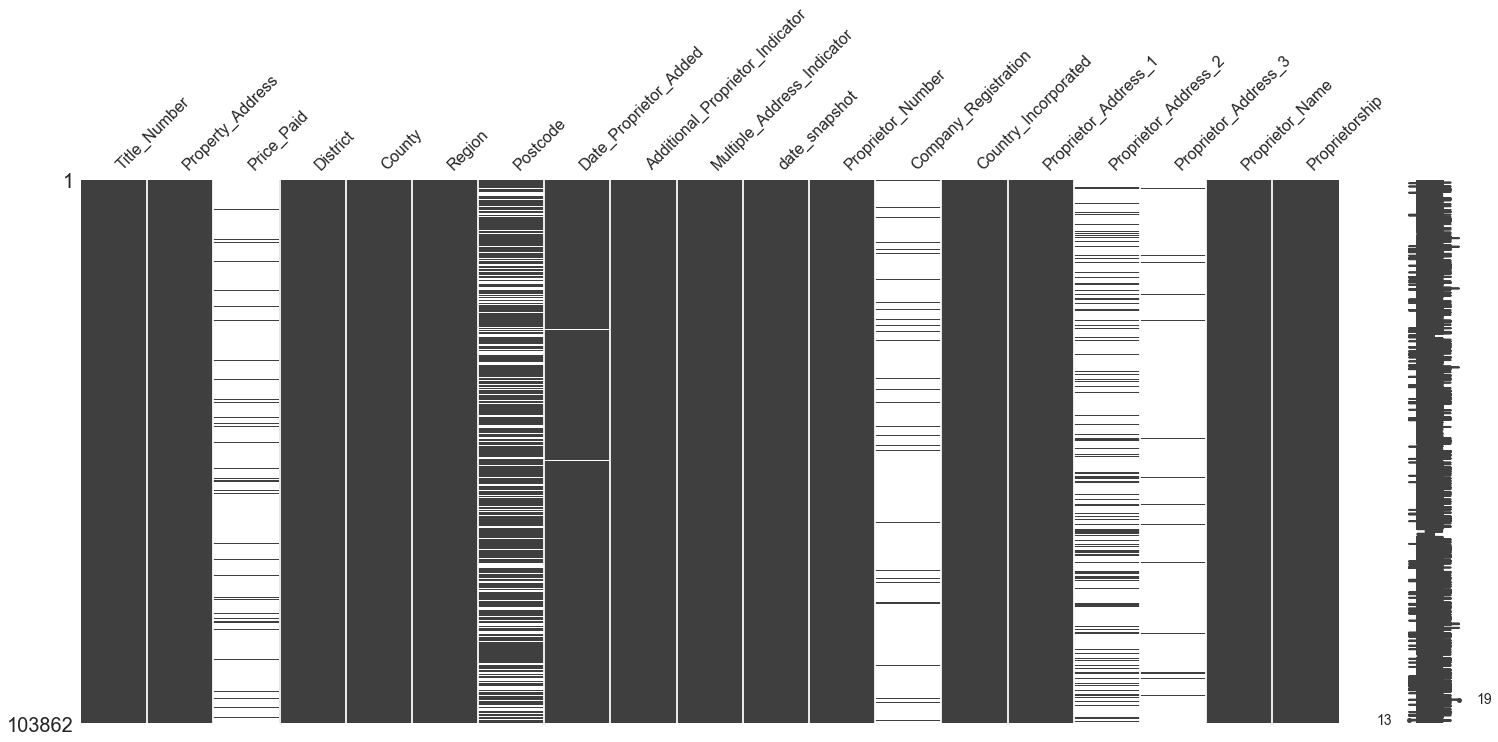

In [52]:
##Look at how well filled out fields are
mgno.matrix(data_2015)

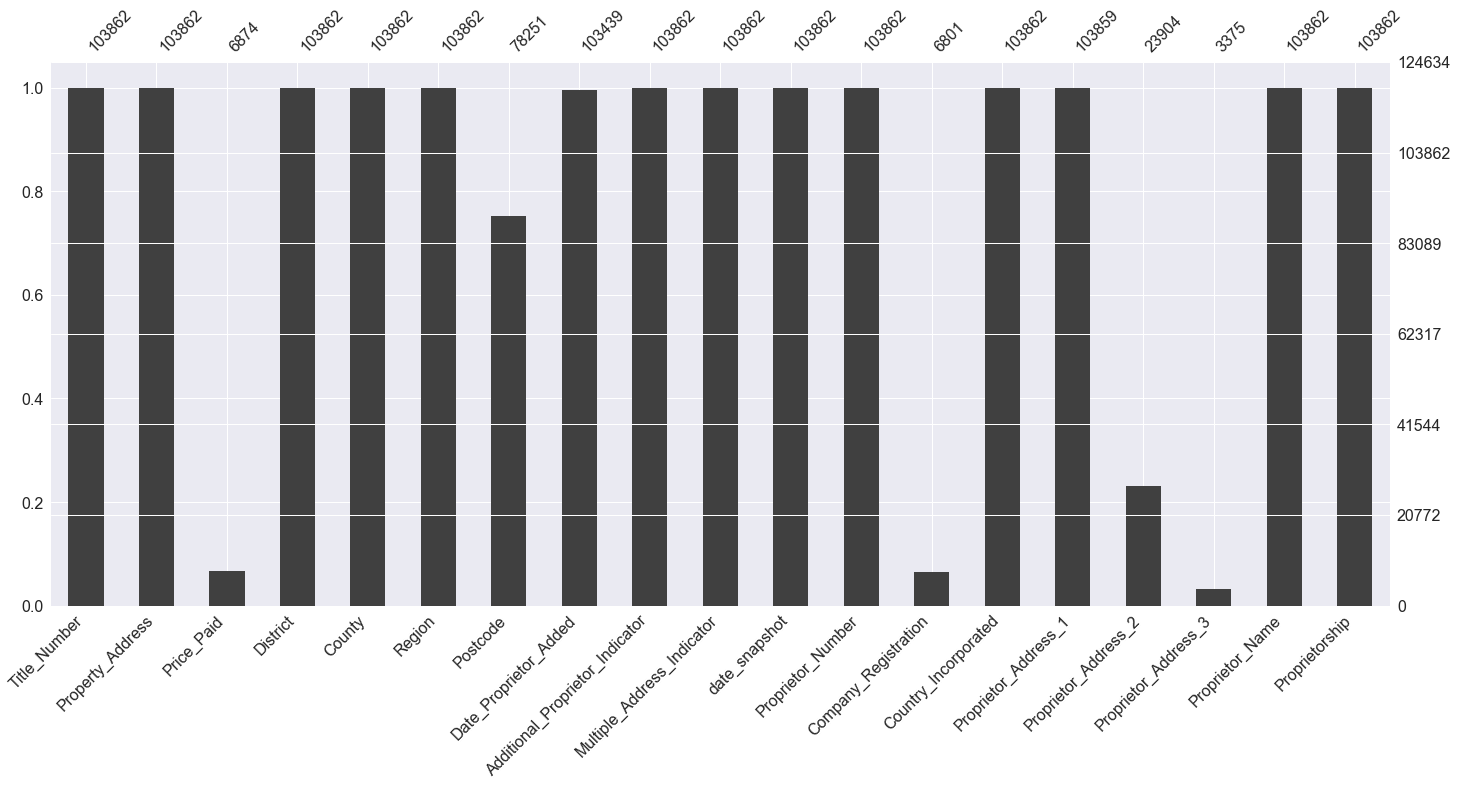

In [53]:
mgno.bar(data_2015)

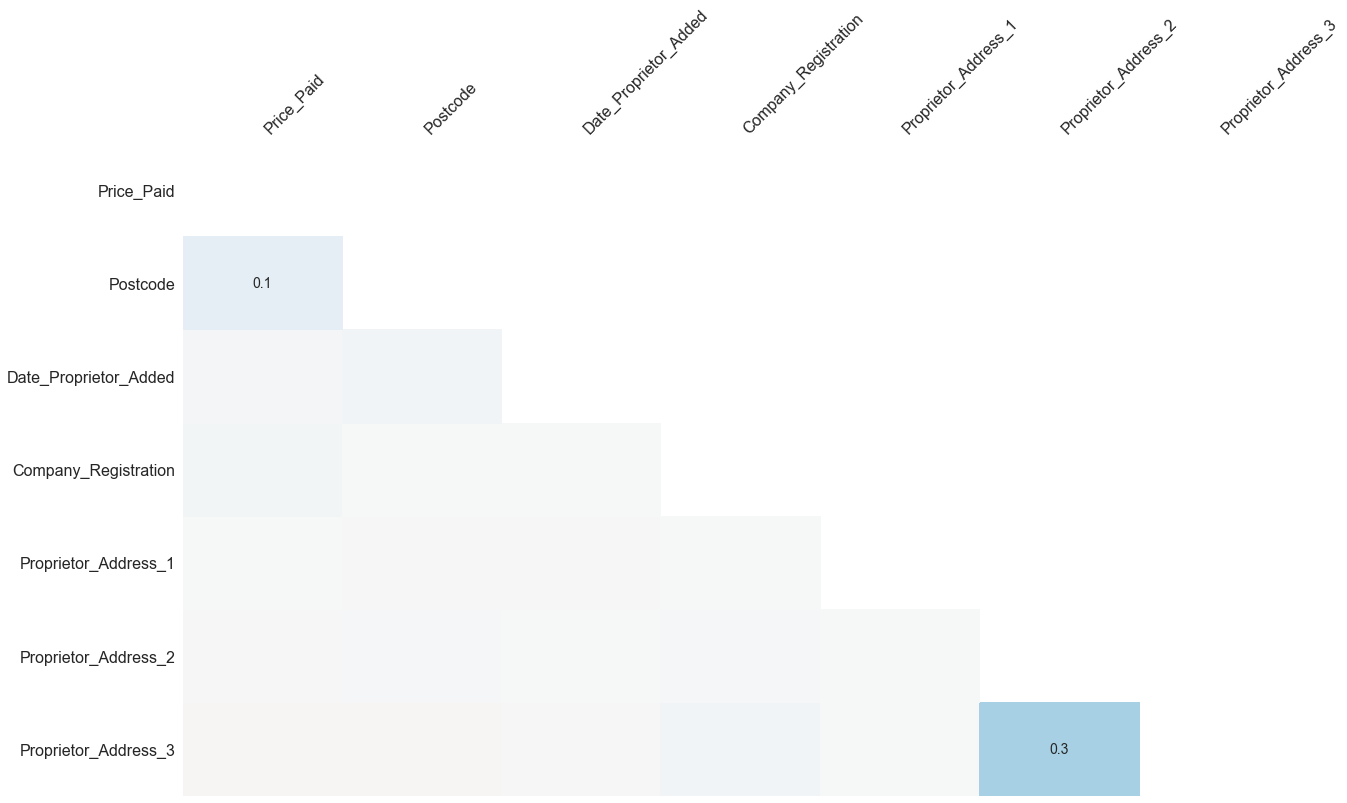

In [54]:
##Correlation matrix for filled values
mgno.heatmap(data_2015)

## Geocode properties

# Data dictionary

Write a data dictionary for each field [TO DO]

# Analysis

How many UK properties are owned by offshore companies compared to 2015?
Offshore here is defined as...

How many are valued at >£1m? What’s the total amount? What’s the sq footage? Have these figures increased since July 2015?

How many properties owned by offshore companies are in London? Has this increased since 2015?

Which areas of UK are most densely populated by buildings owned by anonymous companies? Has this changed since 2015?

Which political constituencies have the highest density of buildings owned by anonymous companies? Has this changed since 2015?

How many properties owned by offshore companies are in Kensington & Chelsea / City of Westminster / City of London? Has this increased since 2015?

What is the breakdown of company registration by jurisdiction? How does this compare to 2015?

How many are owned by companies registered in the British Crown Dependencies and Overseas Territories? Has this changed since 2015?